In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.1.0
TFP version: 0.9.0


# Probabilistic layers and Bayesian neural networks

## Coding tutorials
#### [1. The DistributionLambda layer](#coding_tutorial_1)
#### [2. Probabilistic layers](#coding_tutorial_2)
#### [3. The DenseVariational layer](#coding_tutorial_3)
#### [4. Reparameterization layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## The `DistributionLambda` layer

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(1, input_shape=(2,)),
    tfpl.DistributionLambda(
        lambda t: tfd.Normal(loc=t, scale=1))
])

x_train = tf.random.uniform(shape=[16, 2]) # x_sample: (16, 2)
y_train = model.predict(x_train)

model.compile(loss='mse', optimizer='rmsprop')
model.fit(x_train, y_train, epochs=10)

Train on 16 samples
Epoch 1/10
16/16 [==============================] - 0s 30ms/sample - loss: 2.3377
Epoch 2/10
16/16 [==============================] - 0s 91us/sample - loss: 1.1734
Epoch 3/10
16/16 [==============================] - 0s 88us/sample - loss: 1.1670
Epoch 4/10
16/16 [==============================] - 0s 77us/sample - loss: 1.4244
Epoch 5/10
16/16 [==============================] - 0s 86us/sample - loss: 0.7532
Epoch 6/10
16/16 [==============================] - 0s 69us/sample - loss: 1.5236
Epoch 7/10
16/16 [==============================] - 0s 67us/sample - loss: 2.0789
Epoch 8/10
16/16 [==============================] - 0s 72us/sample - loss: 1.4968
Epoch 9/10
16/16 [==============================] - 0s 75us/sample - loss: 0.9024
Epoch 10/10
16/16 [==============================] - 0s 71us/sample - loss: 1.4581


In [3]:
model = Sequential([
    Dense(1, input_shape=(2,)),
    tfpl.DistributionLambda(
        lambda t: tfd.Normal(loc=t, scale=1),
        convert_to_tensor_fn=tfd.Distribution.sample)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer='rmsprop')
model.fit(x_train, y_train, epochs=10)
print(model(x_train).sample())
print(model(x_train).mean())

Train on 16 samples
Epoch 1/10
16/16 [==============================] - 0s 26ms/sample - loss: 1.3791
Epoch 2/10
16/16 [==============================] - 0s 72us/sample - loss: 1.3771
Epoch 3/10
16/16 [==============================] - 0s 3ms/sample - loss: 1.3757
Epoch 4/10
16/16 [==============================] - 0s 64us/sample - loss: 1.3745
Epoch 5/10
16/16 [==============================] - 0s 95us/sample - loss: 1.3734
Epoch 6/10
16/16 [==============================] - 0s 90us/sample - loss: 1.3725
Epoch 7/10
16/16 [==============================] - 0s 62us/sample - loss: 1.3716
Epoch 8/10
16/16 [==============================] - 0s 69us/sample - loss: 1.3708
Epoch 9/10
16/16 [==============================] - 0s 81us/sample - loss: 1.3701
Epoch 10/10
16/16 [==============================] - 0s 92us/sample - loss: 1.3693
tf.Tensor(
[[ 1.971267  ]
 [ 2.5854063 ]
 [ 0.83609027]
 [-0.14968291]
 [ 0.90953016]
 [ 0.46753353]
 [ 0.70957726]
 [ 1.8887496 ]
 [-0.31026125]
 [-0.02777213]

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create a probabilistic model using the `DistributionLambda` layer

Create a model whose first layer represents:

$$
y = \text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$

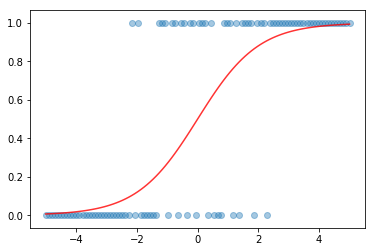

In [5]:
# Create a sigmoid model, first deterministic, then probabilistic

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
        kernel_initializer=tf.constant_initializer(1),
        bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
        convert_to_tensor_fn=tfd.Distribution.sample)
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

In [6]:
# Create a constant input for this model

x = np.array([[0]])
x

array([[0]])

In [7]:
# Explore the feedforward object...

y_model = model(x)
y_model

<tfp.distributions.Bernoulli 'sequential_2_distribution_lambda_2_Bernoulli' batch_shape=[1, 1] event_shape=[] dtype=int32>

In [8]:
# ... and its behaviour under repeated calls

for _ in range(5):
    print(model.predict(x))

[[1]]
[[0]]
[[1]]
[[0]]
[[1]]


#### Use the forward model to create probabilistic training data


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



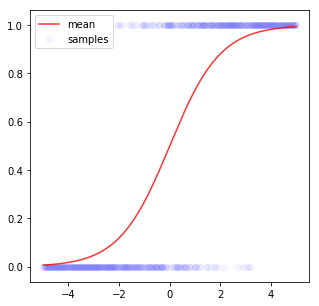

In [9]:
# Use the model to create 500 training points

x_train = np.linspace(-5, 5, 500)[:, np.newaxis]
y_train = model.predict(x_train)

# Plot the data and the mean of the distribution
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x_train, y_train, alpha=0.04, color='blue', label='samples')
ax.plot(x_train, model(x_train).mean().numpy().flatten(), 
        color='red', alpha=0.8, label='mean')
ax.legend()
plt.show()

#### Create a new probabilistic model with the wrong weights

In [10]:
# Create a new version of the model, with the wrong weights

model_untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
        kernel_initializer=tf.constant_initializer(2),
        bias_initializer=tf.constant_initializer(2)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=t),
        convert_to_tensor_fn=tfd.Distribution.sample)
])

#### Train the new model with the negative loglikelihood

In [11]:
# Define negative loglikelihood, which we will use for training

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [12]:
# Compile untrained model

model_untrained.compile(loss=nll, 
    optimizer=RMSprop(learning_rate=0.01))

In [13]:
# Train model, record weights after each epoch

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in range(100):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

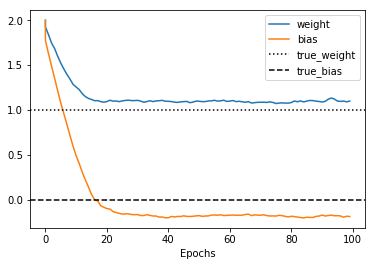

In [14]:
# Plot the model weights as they train, converging to the correct values

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()

***
<a id="coding_tutorial_2"></a>
## Probabilistic layers

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(2), # (batch_size, 2)
    tfpl.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t[..., :1], 
        scale=tf.math.softplus(t[..., 1:]))))
])

x_sample = np.random.uniform(size=(16, 2))\
    .astype(np.float32) # x_sample: (16, 2)

model(x_sample)

<tfp.distributions.Independent 'sequential_9_distribution_lambda_3_Independentsequential_9_distribution_lambda_3_Normal' batch_shape=[16] event_shape=[1] dtype=float32>

In [5]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(8),
    tfpl.IndependentNormal([2, 2])
])

model(x_sample) # x_sample: (16, 2)

<tfp.distributions.Independent 'sequential_3_independent_normal_IndependentNormal_Independentsequential_3_independent_normal_IndependentNormal_Normal' batch_shape=[16] event_shape=[2, 2] dtype=float32>

In [6]:
event_shape = 2

model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(tfpl.IndependentNormal.params_size(event_shape)),
    tfpl.IndependentNormal(event_shape,
        convert_to_tensor_fn=tfd.Distribution.sample)
])

model(x_sample) # x_sample: (16, 2)

<tfp.distributions.Independent 'sequential_4_independent_normal_1_IndependentNormal_Independentsequential_4_independent_normal_1_IndependentNormal_Normal' batch_shape=[16] event_shape=[2] dtype=float32>

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import numpy as np
from sklearn.preprocessing import LabelBinarizer

num_classes = 10

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((3, 3)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(tfpl.OneHotCategorical.params_size(num_classes)),
    tfpl.OneHotCategorical(num_classes)
])
model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.summary()

x_train = np.random.normal(size=(1000, 32, 32, 3))\
    .astype(np.float32)
y_train = np.random.randint(size=(1000,), 
    low=0, high=10, dtype=np.int32)
y_train = LabelBinarizer().fit_transform(y_train)
model.fit(x_train, y_train, epochs=20, verbose=False)
print(f"loss: {model.evaluate(x_train, y_train)}")

# x_test: (1, 32, 32, 3)
x_test = np.random.normal(size=(1, 32, 32, 3))\
    .astype(np.float32)
print(model(x_test).mean())
print(model(x_test).sample())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                102464    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                650       
_________________________________________________________________
one_hot_categorical_3 (OneHo ((None, 10), (None, 10))  0         
Total params: 103,562
Trainable params: 103,562
Non-trainable params: 0
________________________________________________

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

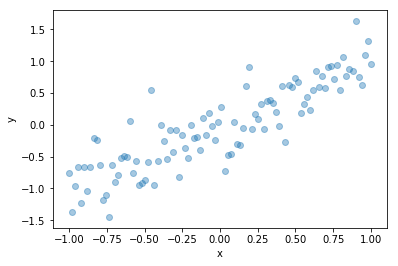

In [14]:
# Create and plot 100 points of training data

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


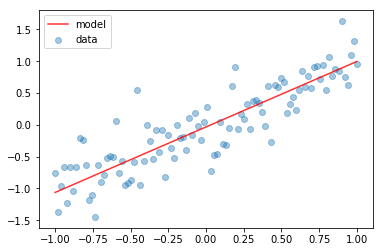

In [15]:
# Create and train deterministic linear model using mean squared error loss

# Create linear regression via Sequential model
model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

In [16]:
# Examine the model predictions

x = np.array([[0]])
y_model = model(x)
y_model

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.03273673]], dtype=float32)>

#### Probabilistic linear regression with both user-defined and learned variance

In [17]:
# Create probabilistic regression with normal distribution as final layer

event_shape = 1
model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), 
        input_shape=(1,)),
    tfpl.IndependentNormal(event_shape)
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 2)                 4         
_________________________________________________________________
independent_normal_2 (Indepe ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Train model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=200, verbose=False)

In [19]:
# Examine the distribution created as a feedforward value

y_model = model(x)
y_model

<tfp.distributions.Independent 'sequential_11_independent_normal_2_IndependentNormal_Independentsequential_11_independent_normal_2_IndependentNormal_Normal' batch_shape=[1] event_shape=[1] dtype=float32>


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



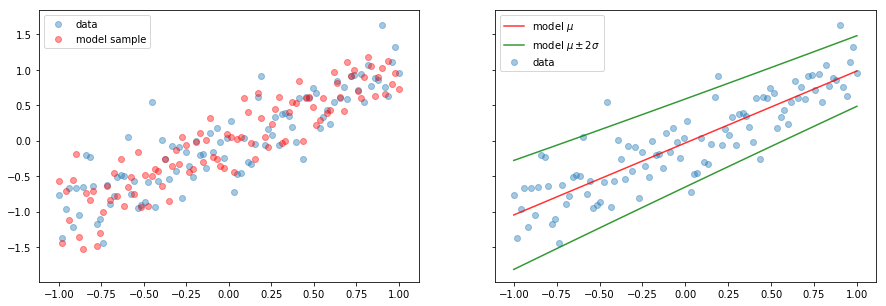

In [20]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.4, label='data')
ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.4, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

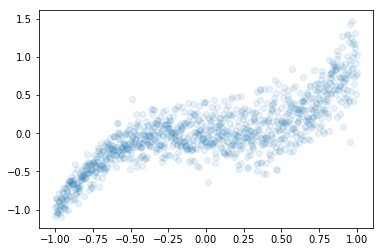

In [21]:
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [22]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 18        
_________________________________________________________________
independent_normal_3 (Indepe ((None, 1), (None, 1))    0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Train model

model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 0s 194us/sample - loss: 0.0432


0.043166181921958924


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



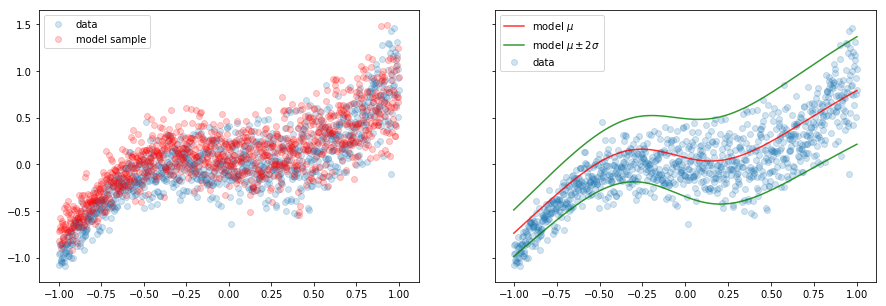

In [24]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='data')
ax1.scatter(x_train, y_sample, alpha=0.2, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()

***
<a id="coding_tutorial_3"></a>
## The `DenseVariational` layer

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    Dense(16, activation='relu', input_shape=(8,)),
    Dense(2),
    tfpl.IndependentNormal(1)])

model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))

x_train = tf.random.uniform(shape=(1000, 8))
y_train = tf.random.uniform(shape=(1000,), minval=0, maxval=1, 
    dtype=tf.float32)
model.fit(x_train, y_train, epochs=200)

Train on 1000 samples
Epoch 1/200
1000/1000 [==============================] - 1s 973us/sample - loss: 0.7633
Epoch 2/200
1000/1000 [==============================] - 0s 124us/sample - loss: 0.5593
Epoch 3/200
1000/1000 [==============================] - 0s 196us/sample - loss: 0.4085
Epoch 4/200
1000/1000 [==============================] - 0s 183us/sample - loss: 0.3274
Epoch 5/200
1000/1000 [==============================] - 0s 117us/sample - loss: 0.2935
Epoch 6/200
1000/1000 [==============================] - 0s 180us/sample - loss: 0.2783
Epoch 7/200
1000/1000 [==============================] - 0s 114us/sample - loss: 0.2651
Epoch 8/200
1000/1000 [==============================] - 0s 106us/sample - loss: 0.2551
Epoch 9/200
1000/1000 [==============================] - 0s 180us/sample - loss: 0.2463
Epoch 10/200
1000/1000 [==============================] - 0s 112us/sample - loss: 0.2398
Epoch 11/200
1000/1000 [==============================] - 0s 105us/sample - loss: 0.2330
Epoch 12

Epoch 93/200
1000/1000 [==============================] - 0s 106us/sample - loss: 0.1539
Epoch 94/200
1000/1000 [==============================] - 0s 105us/sample - loss: 0.1555
Epoch 95/200
1000/1000 [==============================] - 0s 171us/sample - loss: 0.1551
Epoch 96/200
1000/1000 [==============================] - 0s 111us/sample - loss: 0.1548
Epoch 97/200
1000/1000 [==============================] - 0s 112us/sample - loss: 0.1524
Epoch 98/200
1000/1000 [==============================] - 0s 98us/sample - loss: 0.1511
Epoch 99/200
1000/1000 [==============================] - 0s 104us/sample - loss: 0.1522
Epoch 100/200
1000/1000 [==============================] - 0s 176us/sample - loss: 0.1521
Epoch 101/200
1000/1000 [==============================] - 0s 115us/sample - loss: 0.1535
Epoch 102/200
1000/1000 [==============================] - 0s 104us/sample - loss: 0.1529
Epoch 103/200
1000/1000 [==============================] - 0s 171us/sample - loss: 0.1512
Epoch 104/200
1000

In [7]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return lambda t: tfd.Independent(
        tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
            reinterpreted_batch_ndims=1)

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), 
            dtype=dtype),
        tfpl.IndependentNormal(n, 
            convert_to_tensor_fn=tfd.Distribution.sample)])

# ELBO:
# q = q(w | theta)
# E_{w ~ q}[log p(D | w)] - KL[q || p]
#     = Sum_i E_{w ~ q}[log p(D_i | w)] - KL[q || p]

# For a minibatch:
# N/B * Sum_j E_{w ~ q}[log p(D_j | w)] - KL[q || p]

# Per example loss:
# 1/B * Sum_j E_{w ~q}[log p(D_j | w)] - 1/N * KL[q || p]

N = 1000
model = Sequential([
    tfpl.DenseVariational(16, posterior, prior, kl_weight=1/N,
        kl_use_exact=True, activation='relu', input_shape=(8,)),
    tfpl.DenseVariational(2, posterior, prior, kl_weight=1/N,
        kl_use_exact=True),
    tfpl.IndependentNormal(1)])

model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))

x_train = tf.random.uniform(shape=(N, 8))
y_train = tf.random.uniform(shape=(N,), minval=0, maxval=1, 
    dtype=tf.float32)
model.fit(x_train, y_train, epochs=200)

Train on 1000 samples
Epoch 1/200
1000/1000 [==============================] - 2s 2ms/sample - loss: 1236525.0521
Epoch 2/200
1000/1000 [==============================] - 0s 285us/sample - loss: 5443.3559
Epoch 3/200
1000/1000 [==============================] - 0s 218us/sample - loss: 11662.7090
Epoch 4/200
1000/1000 [==============================] - 0s 282us/sample - loss: 465614.1164
Epoch 5/200
1000/1000 [==============================] - 0s 204us/sample - loss: 9617215.0224
Epoch 6/200
1000/1000 [==============================] - 0s 203us/sample - loss: 8009.9045
Epoch 7/200
1000/1000 [==============================] - 0s 203us/sample - loss: 87433.1722
Epoch 8/200
1000/1000 [==============================] - 0s 282us/sample - loss: 1499.6003 loss: 142
Epoch 9/200
1000/1000 [==============================] - 0s 203us/sample - loss: 401208.6854
Epoch 10/200
1000/1000 [==============================] - 0s 197us/sample - loss: 1178.9880
Epoch 11/200
1000/1000 [=======================

Epoch 90/200
1000/1000 [==============================] - 0s 192us/sample - loss: 6.3077
Epoch 91/200
1000/1000 [==============================] - 0s 194us/sample - loss: 5.4686
Epoch 92/200
1000/1000 [==============================] - 0s 116us/sample - loss: 13.7637
Epoch 93/200
1000/1000 [==============================] - 0s 122us/sample - loss: 35.0257
Epoch 94/200
1000/1000 [==============================] - 0s 186us/sample - loss: 8.6977
Epoch 95/200
1000/1000 [==============================] - 0s 111us/sample - loss: 5.4058
Epoch 96/200
1000/1000 [==============================] - 0s 191us/sample - loss: 5.0027
Epoch 97/200
1000/1000 [==============================] - 0s 115us/sample - loss: 22.4543
Epoch 98/200
1000/1000 [==============================] - 0s 188us/sample - loss: 28.3223
Epoch 99/200
1000/1000 [==============================] - 0s 194us/sample - loss: 15.2752
Epoch 100/200
1000/1000 [==============================] - 0s 113us/sample - loss: 32.0275
Epoch 101/200


Epoch 181/200
1000/1000 [==============================] - 0s 119us/sample - loss: 1.7606
Epoch 182/200
1000/1000 [==============================] - 0s 190us/sample - loss: 1.4009
Epoch 183/200
1000/1000 [==============================] - 0s 117us/sample - loss: 1.3420
Epoch 184/200
1000/1000 [==============================] - 0s 188us/sample - loss: 1.3912
Epoch 185/200
1000/1000 [==============================] - 0s 186us/sample - loss: 1.5165
Epoch 186/200
1000/1000 [==============================] - 0s 121us/sample - loss: 1.3399
Epoch 187/200
1000/1000 [==============================] - 0s 188us/sample - loss: 1.3280
Epoch 188/200
1000/1000 [==============================] - 0s 196us/sample - loss: 1.2700
Epoch 189/200
1000/1000 [==============================] - 0s 114us/sample - loss: 1.4265
Epoch 190/200
1000/1000 [==============================] - 0s 192us/sample - loss: 1.2315
Epoch 191/200
1000/1000 [==============================] - 0s 190us/sample - loss: 1.4150
Epoch 192/

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

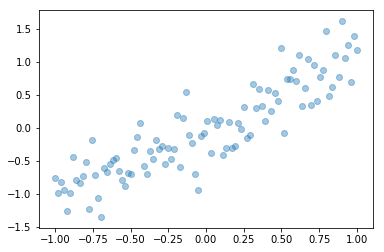

In [3]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.show()

#### Create the prior and posterior distribution for model weights

In [4]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable

def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([tfpl.DistributionLambda(
        lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n),
            scale_diag=tf.ones(n)))])
    return prior_model

In [5]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),
            dtype=dtype),
        tfpl.MultivariateNormalTriL(n)])
    return posterior_model

#### Aside: analytical posterior

In this tutorial, we're using a variational posterior because, in most settings, it's not possible to derive an analytical one. However, in this simple setting, it is possible. Specifically, running a Bayesian linear regression on $x_i$ and $y_i$ with $i=1, \ldots, n$ and a unit Gaussian prior on both $\alpha$ and $\beta$:

$$
y_i = \alpha + \beta x_i + \epsilon_i, \quad 
\epsilon_i \sim N(0, \sigma^2), \quad 
\alpha \sim N(0, 1), \quad 
\beta \sim N(0, 1)
$$

gives a multivariate Gaussian posterior on $\alpha$ and $\beta$:

$$
\begin{pmatrix}
\alpha \\
\beta
\end{pmatrix}
\sim
N(\mathbf{\mu}, \mathbf{\Sigma})
$$
where
$$ 
\mathbf{\mu}
= 
\mathbf{\Sigma} 
\begin{pmatrix}
\hat{n} \bar{y} \\
\hat{n} \overline{xy}
\end{pmatrix},
\quad
\mathbf{\Sigma} = 
\frac{1}{(\hat{n} + 1)(\hat{n} \overline{x^2} + 1) - \hat{n}^2 \bar{x}^2}
\begin{pmatrix}
\hat{n} \overline{x^2} + 1 & -\hat{n} \bar{x} \\
-\hat{n} \bar{x} & \hat{n} + 1
\end{pmatrix}.
$$

In the above, $\hat{n} = \frac{n}{\sigma^2}$ and $\bar{t} = \frac{1}{n}\sum_{i=1}^n t_i$ for any $t$. In general, however, it's not possible to determine the analytical form for the posterior. For example, in models with a hidden layer with nonlinear activation function, the analytical posterior cannot be determined in general, and variational methods as below are useful.

#### Create the model with `DenseVariational` layers

In [7]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model = Sequential([
    tfpl.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0], kl_use_exact=True)])

model.compile(loss=MeanSquaredError(),
    optimizer=RMSprop(learning_rate=0.005))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_1 (DenseVa (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


#### Train model and inspect

In [8]:
# Fit the model, just like a deterministic linear regression

model.fit(x_train, y_train, epochs=500, verbose=False)

In [9]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [1.0331362  0.01086524]
posterior covariance:  [ 0.01758878 -0.00459222]
                       [-0.00459222  0.00681984]


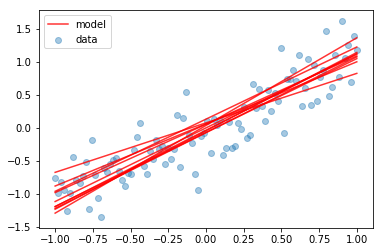

In [11]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

#### Explore the effect of sample size

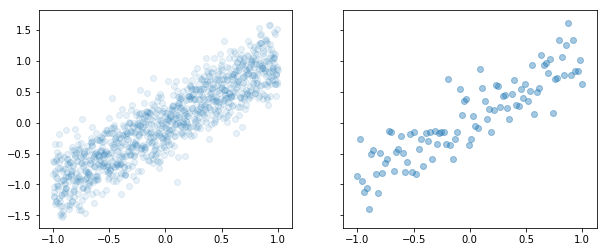

In [12]:
# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
plt.show()

In [13]:
# Train a model on each dataset

model_1000 = Sequential([
    tfpl.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/1000)])

model_100 = Sequential([
    tfpl.DenseVariational(input_shape=(1,), units=1,
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), 
    optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), 
    optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

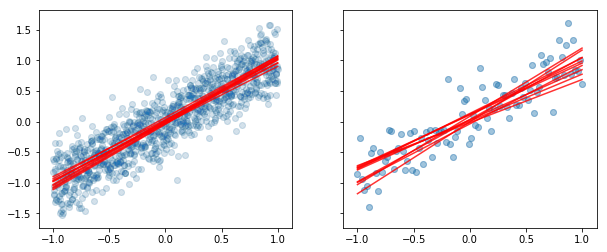

In [15]:
# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), 
    sharex=True, sharey=True)

for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)

plt.show()

#### Put it all together: nonlinear probabilistic regression with weight uncertainty

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

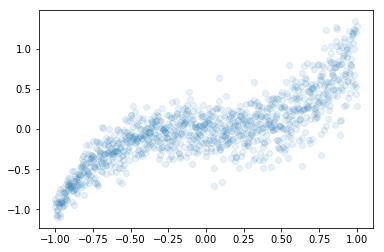

In [16]:
# Create and plot 1000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [24]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8, input_shape=(1,),
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0], activation='sigmoid'),
    
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
        make_prior_fn=prior, make_posterior_fn=posterior,
        kl_weight=1/x_train.shape[0]),
    
    tfpl.IndependentNormal(1)])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_8 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_9 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal_2 (Indepe ((None, 1), (None, 1))    0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train the model

model.fit(x_train, y_train, epochs=1000, verbose=False)
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 1s 983us/sample - loss: 0.0074


0.00743547534942627

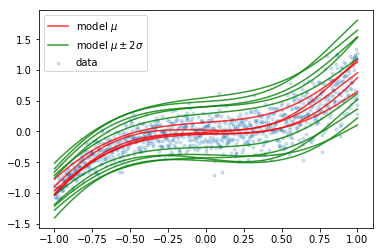

In [27]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

***
<a id="coding_tutorial_4"></a>
## Reparameterization layers

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, MaxPool2D
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3], 
        activation='relu', input_shape=(28, 28, 1),
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_prior_fn=tfpl.default_multivariate_normal_fn),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_1  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


In [3]:
def custom_multivariate_normal_fn(dtype, shape, name, trainable, 
    add_variable_fn):
    normal = tfd.Normal(loc=tf.zeros(shape, dtype), 
        scale=2 * tf.ones(shape, dtype))
    batch_ndims = tf.size(normal.batch_shape_tensor())
    return tfd.Independent(normal, 
        reinterpreted_batch_ndims=batch_ndims)

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3], 
        activation='relu', input_shape=(28, 28, 1),
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_prior_fn=custom_multivariate_normal_fn),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_2  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_2 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_2 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


In [9]:
dataset_size = 1000

model = Sequential([
    tfpl.Convolution2DReparameterization(16, [3, 3], 
        activation='relu', input_shape=(28, 28, 1),
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        kernel_posterior_tensor_fn=tfd.Distribution.sample,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=True),
        bias_posterior_tensor_fn=tfd.Distribution.sample,
        bias_prior_fn=None,
        kernel_divergence_fn=(lambda q, p, _: tfd.kl_divergence(q, p) / dataset_size)),
    MaxPool2D(3),
    Flatten(),
    tfpl.DenseReparameterization(
        tfpl.OneHotCategorical.params_size(10)),
    tfpl.OneHotCategorical(10)])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_reparameterization_8  (None, 26, 26, 16)        304       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_reparameterization_8 ( (None, 10)                20490     
_________________________________________________________________
one_hot_categorical_8 (OneHo ((None, 10), (None, 10))  0         
Total params: 20,794
Trainable params: 20,794
Non-trainable params: 0
_________________________________________________________________


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt

#### Load in the HAR dataset

You'll be working with the [Human Activity Recognition (HAR) Using Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. It consists of the readings from an accelerometer (which measures acceleration) carried by a human doing different activities. The six activities are walking horizontally, walking upstairs, walking downstairs, sitting, standing and laying down. The accelerometer is inside a smartphone, and, every 0.02 seconds (50 times per second), it takes six readings: linear and gyroscopic acceleration in the x, y and z directions. See [this link](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) for details and download. If you use it in your own research, please cite the following paper:

- Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 

The goal is to use the accelerometer data to predict the activity.

In [3]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = 'data/HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

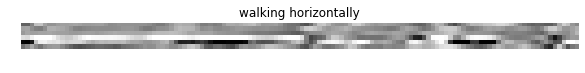

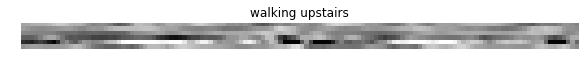

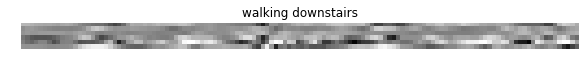

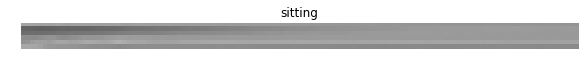

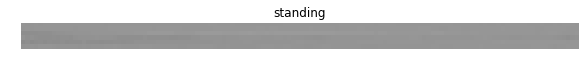

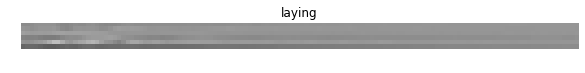

In [4]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

#### 1D deterministic convolutional neural network

In [5]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


#### Probabilistic 1D convolutional neural network, with both weight and output uncertainty

In [7]:
# Create probablistic model with the following layers:
#  - Conv1D
#  - MaxPooling
#  - Flatten
#  - Dense
#  - OneHotCategorical

divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / x_train.shape[0]

model = Sequential([
    tfpl.Convolution1DReparameterization(input_shape=(128, 6),
        filters=8, kernel_size=16, activation='relu',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn),
    MaxPooling1D(pool_size=16),
    Flatten(),
    tfpl.DenseReparameterization(
        units=tfpl.OneHotCategorical.params_size(6), activation=None,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn=divergence_fn,
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn=divergence_fn),
    tfpl.OneHotCategorical(6)])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_1  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization_1 ( (None, 6)                 684       
_________________________________________________________________
one_hot_categorical_1 (OneHo ((None, 6), (None, 6))    0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [9]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [10]:
# Train the model

model.fit(x_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

2947/2947 [==============================] - 1s 202us/sample - loss: 0.8495 - accuracy: 0.7251


[0.8494912760264598, 0.7251442]

#### Inspect model performance

In [11]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


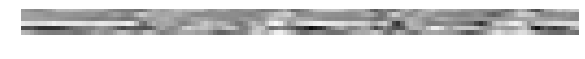

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


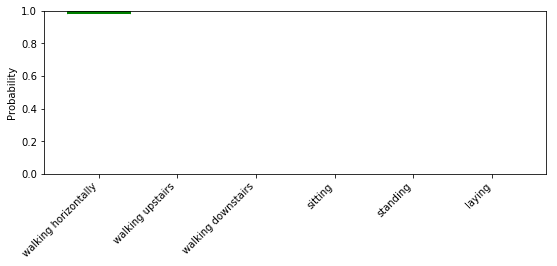

In [13]:
analyse_model_predictions(image_num=79)

------------------------------
Accelerometer data:


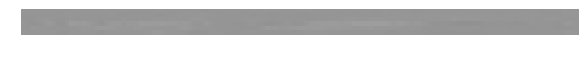

------------------------------
True activity: standing

------------------------------
Model estimated probabilities:


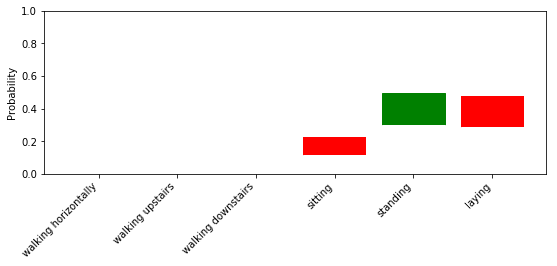

In [14]:
analyse_model_predictions(image_num=633)

------------------------------
Accelerometer data:


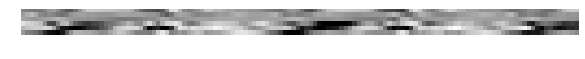

------------------------------
True activity: walking horizontally

------------------------------
Model estimated probabilities:


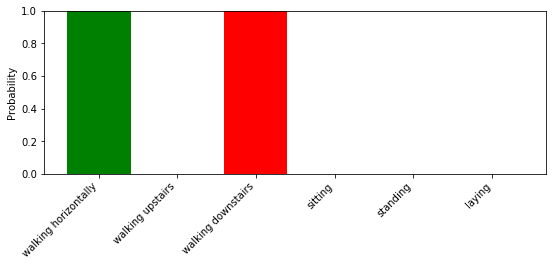

In [15]:
analyse_model_predictions(image_num=1137)